In [1]:
#! pip install catboost -U
#! pip install lightgbm -U
#! pip install scikit-optimize -U
#!pip install  imbalanced-learn -U
#! pip install phik -U

# Ниединогоразрыва.ком

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных</a></span><ul class="toc-item"><li><span><a href="#План-работы" data-toc-modified-id="План-работы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>План работы</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследование" data-toc-modified-id="Исследование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследование</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Функции-для-метрик" data-toc-modified-id="Функции-для-метрик-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Функции для метрик</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Dummy" data-toc-modified-id="Dummy-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Dummy</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Итоговый-тест" data-toc-modified-id="Итоговый-тест-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоговый тест</a></span></li><li><span><a href="#Отчет" data-toc-modified-id="Отчет-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Отчет</a></span></li></ul></div>

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.  

# Описание услуг  

Оператор предоставляет два основных типа услуг:   

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.  
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).    

Также доступны такие услуги:  

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);  
- Выделенная линия технической поддержки (*TechSupport*);  
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);  
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).  

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.  

# Описание данных  

Данные состоят из файлов, полученных из разных источников:  
    
- `contract.csv` — информация о договоре;  
- `personal.csv` — персональные данные клиента;  
- `internet.csv` — информация об интернет-услугах;  
- `phone.csv` — информация об услугах телефонии.  

Во всех файлах столбец `customerID` содержит код клиента.  

Информация о договорах актуальна на 1 февраля 2020.

## Загрузка данных

In [2]:
import pandas as pd
import numpy as np
import re
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv').set_index('customerID')
    personal = pd.read_csv('/datasets/final_provider/personal.csv').set_index('customerID')
    internet = pd.read_csv('/datasets/final_provider/internet.csv').set_index('customerID')
    phone  = pd.read_csv('/datasets/final_provider/phone.csv').set_index('customerID')
except:
    contract = pd.read_csv('contract.csv').set_index('customerID')
    personal = pd.read_csv('personal.csv').set_index('customerID')
    internet = pd.read_csv('internet.csv').set_index('customerID')
    phone = pd.read_csv('phone.csv').set_index('customerID')

Назначу имена датасетам, для удобства

In [4]:
contract.name = 'Contract'
personal.name = 'Personal'
internet.name = 'Internet'
phone.name = 'Phone'

## Обзор данных

Функция для просмотра основных данных по датасету

In [5]:
def view(df):
    display(df.head())
    print('')
    print(df.info())
    print('')
    print(f'Размер: {df.shape}')
    print('')
    print(f'Дубликаты: {df.duplicated().sum()}')
    print('')
    print(f'Пропуски:')
    print(df.isna().sum())
    print('_'*100)

In [6]:
df = [contract, personal, internet, phone]

In [7]:
for i in df:
    print(i.name)
    view(i)

Contract


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB
None

Размер: (7043, 7)

Дубликаты: 45

Пропуски:
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
____________________________________________________________________________________________________
Personal


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No



<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
None

Размер: (7043, 4)

Дубликаты: 7027

Пропуски:
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
____________________________________________________________________________________________________
Internet


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB
None

Размер: (5517, 7)

Дубликаты: 5389

Пропуски:
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
____________________________________________________________________________________________________
Phone


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes



<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB
None

Размер: (6361, 1)

Дубликаты: 6359

Пропуски:
MultipleLines    0
dtype: int64
____________________________________________________________________________________________________


### План работы


1) Подготовить данные.  
* Привести названия столбцов к змеиному регистру;  
* Изменить типы данных; 
* Проверить contract['TotalCharges']
* Добавить столбец с длительностью обслуживания;  
* Удалить неинформативные столбцы;  
* Составление единой таблицы со всеми данными для модели;  
* Провести прямое кодирование признаков. 
* Ресемплинг

2) Подготовка признаков.     
* Выделение целевого признака как факт окончания обслуживания;  
* Разбивание датасета на выборки;  
* Разделение на features и target со смешиванием данных.  

3) Выбор моделей.   
* Использование и обучение моделей классификации, например, CatBoost, LGBM и т.д.    
* Оценка эффективности моделей на кросс-валидации
* Финальное тестирование лучшей модели.   

## Предобработка данных

Во-первых, разберемся откуда у 'TotalCharges' тип 'object'

In [8]:
strings = []
for i in contract['TotalCharges']:
    try: 
        i = float(i)
    except:
        strings.append(i)
strings        

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

In [9]:
contract[contract['TotalCharges'] == ' ']

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


Т.к. это клиенты, только оформившие услуги, они еще не оплачивали свой первый договор( или оплатили один раз, но так геморройнее, а разницы нет)

In [10]:
contract[contract['TotalCharges'] == ' '] = 0
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

Объеденим таблицы по customer_id методом 'left', чтобы никого не потерять

In [11]:
data_full = contract.merge(internet, how='left', on='customerID')
data_full = data_full.merge(personal, how='left', on='customerID')
data_full = data_full.merge(phone, how='left', on='customerID')

In [12]:
data_full.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [13]:
data_full.isna().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

Видим, что при объединении таблиц появились пропуски. Скорее всего это указывает на то, что данные пользователи не пользовались этими услугами, так что заменим их на 0

In [14]:
data_full.fillna(0, inplace=True)

Приветем столбцы к змеиному регистру

In [15]:
def camel_to_snake(data):
    for name in data.columns:
        rena = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
        rena = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()
        data = data.rename(columns={name:rena})
    return data
data_full = camel_to_snake(data_full)

А даты - к датам

In [16]:
data_full['begin_date'] = pd.to_datetime(data_full['begin_date'], format='%Y-%m-%d')
data_full.loc[data_full['end_date']=='No', 'end_date'] = np.nan
data_full['end_date'] = pd.to_datetime(data_full['end_date'], format='%Y-%m-%d')

In [17]:
data_full['paperless_billing'].unique() #Чтобы позже не было трудностей заменим сразу на 0 и 1

array(['Yes', 'No', 0], dtype=object)

In [18]:
data_full.replace('No', 0, inplace=True)
data_full.replace('Yes', 1, inplace=True)

In [19]:
data_full.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,1,0,0,0,0,Female,0,1,0,0
5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,DSL,1,0,1,0,0,0,Male,0,0,0,0
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,1,0,0,0,0,Male,0,0,0,0
7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,DSL,1,0,1,1,0,0,Male,0,0,0,0
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Fiber optic,0,0,0,0,0,0,Female,0,0,0,0


Применим кодирование к данным, чтобы подготовить их для модели

In [20]:
cat_features = data_full.columns.drop(['begin_date', 'end_date','monthly_charges', 'total_charges'])

In [21]:
df_ohe = pd.get_dummies(data_full, columns=cat_features, drop_first=True)

In [22]:
df_ohe.columns = df_ohe.columns.str.lower()
df_ohe.head()

,begin_date,end_date,monthly_charges,total_charges,type_month-to-month,type_one year,type_two year,paperless_billing_1,payment_method_bank transfer (automatic),payment_method_credit card (automatic),...,online_backup_1,device_protection_1,tech_support_1,streaming_tv_1,streaming_movies_1,gender_male,senior_citizen_1,partner_1,dependents_1,multiple_lines_1
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,29.85,29.85,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
5575-GNVDE,2017-04-01,NaT,56.95,1889.50,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3668-QPYBK,2019-10-01,2019-12-01,53.85,108.15,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
7795-CFOCW,2016-05-01,NaT,42.30,1840.75,0,1,0,0,1,0,...,0,1,1,0,0,1,0,0,0,0
9237-HQITU,2019-09-01,2019-11-01,70.70,151.65,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   begin_date                                7043 non-null   datetime64[ns]
 1   end_date                                  1880 non-null   datetime64[ns]
 2   monthly_charges                           7043 non-null   float64       
 3   total_charges                             7043 non-null   float64       
 4   type_month-to-month                       7043 non-null   uint8         
 5   type_one year                             7043 non-null   uint8         
 6   type_two year                             7043 non-null   uint8         
 7   paperless_billing_1                       7043 non-null   uint8         
 8   payment_method_bank transfer (automatic)  7043 non-null   uint8         
 9   payment_method_credi

Создадим целевой признак на основании: окончен ли контракт или нет

In [24]:
df_ohe['exit'] = (df_ohe['end_date'].notna()) * 1

In [25]:
df_ohe['end_date'].fillna(pd.to_datetime('2020-02-01', format='%Y-%m-%d'), inplace=True)

Добавим длительность обслуживания и удалим столбцы с времеными значениями

In [26]:
df_ohe['duration'] = (df_ohe['end_date'] - df_ohe['begin_date'])

In [27]:
df_ohe = df_ohe.drop(['begin_date', 'end_date'], axis=1)

In [28]:
df_ohe['duration'] = df_ohe['duration'].dt.days

## Исследование

Для начала давайте посмотрим на расспределение признаков

In [29]:
df_ohe.columns

Index(['monthly_charges', 'total_charges', 'type_month-to-month',
       'type_one year', 'type_two year', 'paperless_billing_1',
       'payment_method_bank transfer (automatic)',
       'payment_method_credit card (automatic)',
       'payment_method_electronic check', 'payment_method_mailed check',
       'internet_service_dsl', 'internet_service_fiber optic',
       'online_security_1', 'online_backup_1', 'device_protection_1',
       'tech_support_1', 'streaming_tv_1', 'streaming_movies_1', 'gender_male',
       'senior_citizen_1', 'partner_1', 'dependents_1', 'multiple_lines_1',
       'exit', 'duration'],
      dtype='object')

In [30]:
cat_features = df_ohe.columns.drop(['monthly_charges', 'total_charges', 'duration'])
col_features =['monthly_charges', 'total_charges', 'duration']

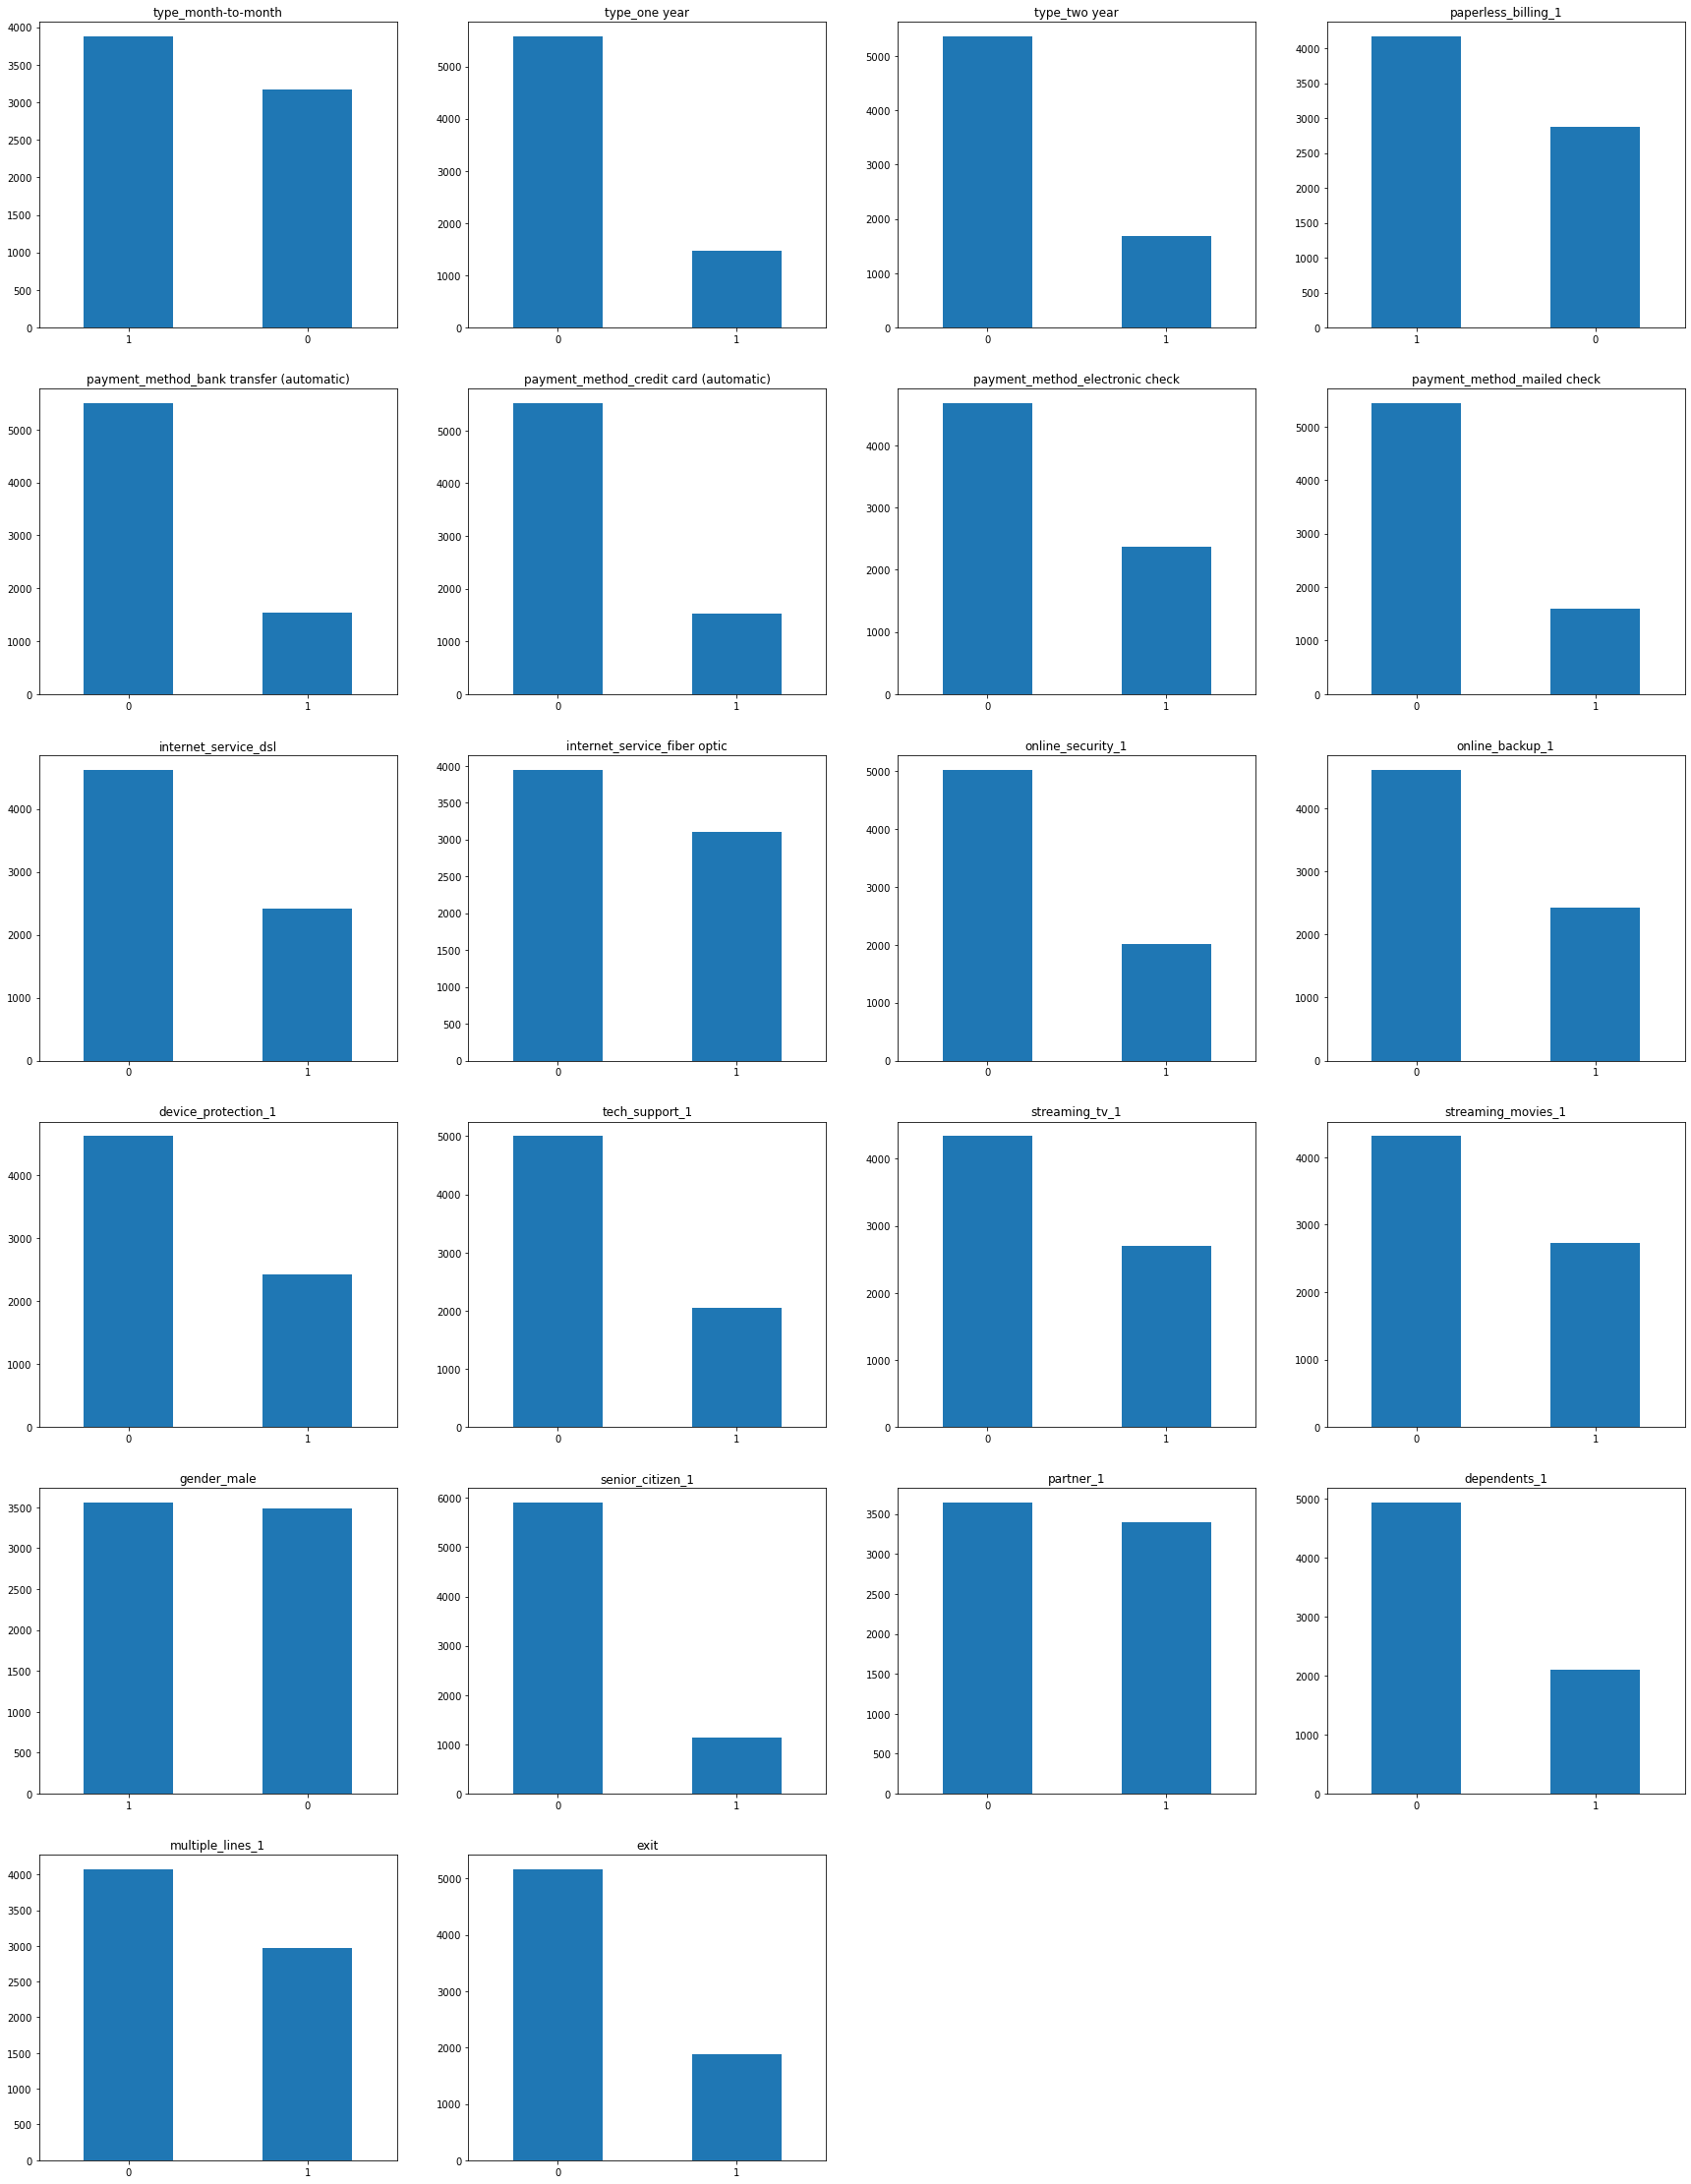

In [31]:
i=1
plt.figure(figsize=(30,40))
for col in cat_features:
    plt.subplot(6,4,i)
    df_ohe[col].value_counts().plot(
        kind='bar', 
        title=col, 
        rot=0)
    i+=1
    

Довольно противный вышел график, но по нему видно, что часть признаков(gender, partner) бесполезна, удалим их позже

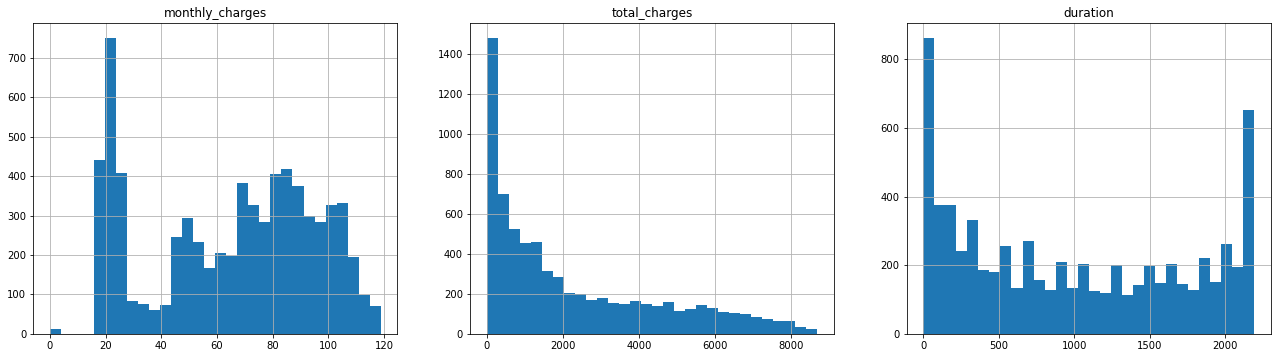

In [32]:
i=1
plt.figure(figsize=(30,40))
for col in col_features:
    plt.subplot(6,4,i)
    df_ohe[col].hist(bins=30)
    plt.title(col)
    i+=1

Видим несколько пиков у ежемесячной оплаты(условные категории клиентов) и срока обслуживания(Новые пользователи и лояльные), в то время, как общая оплата снижается.  
Можно предположить, что лояльные клиенты находятся в нижнем ценовом сегменте.   
Попробуем выделить сегменты и рассмотреть их

In [33]:
'''def segments(row):
    monthly_charges = row['monthly_charges']
    if monthly_charges <= 30.0:
        return 1
    if monthly_charges <= 60.0:
        return 2
    return 3
df_ohe['segment'] = df_ohe.apply(segments, axis=1)'''

"def segments(row):\n    monthly_charges = row['monthly_charges']\n    if monthly_charges <= 30.0:\n        return 1\n    if monthly_charges <= 60.0:\n        return 2\n    return 3\ndf_ohe['segment'] = df_ohe.apply(segments, axis=1)"

А теперь посмотрим на корреляцию признаков

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'type_month-to-month', 'type_one year', 'type_two year', 'paperless_billing_1', 'payment_method_bank transfer (automatic)', 'payment_method_credit card (automatic)', 'payment_method_electronic check', 'payment_method_mailed check', 'internet_service_dsl', 'internet_service_fiber optic', 'online_security_1', 'online_backup_1', 'device_protection_1', 'tech_support_1', 'streaming_tv_1', 'streaming_movies_1', 'gender_male', 'senior_citizen_1', 'partner_1', 'dependents_1', 'multiple_lines_1', 'exit', 'duration']


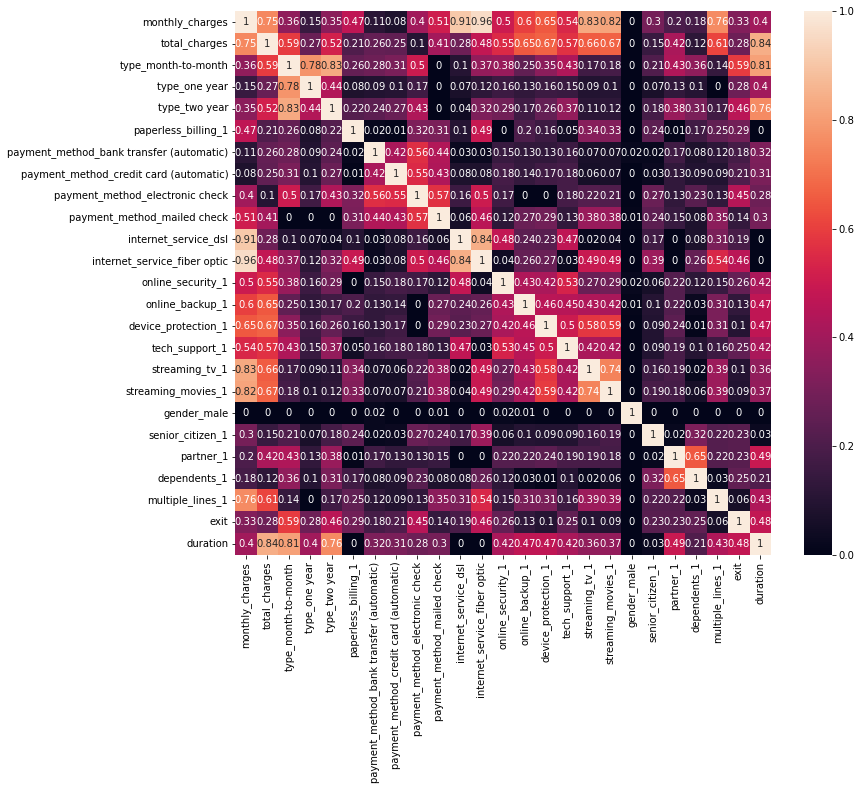

In [34]:
phik_overview = df_ohe.phik_matrix();
ax,fig = plt.subplots(figsize=(12,10));
sns.heatmap(phik_overview.round(2), annot=True);

Удалим столбцы gender и customer_id т.к. никакой полезности для модели они не несут и столбец 'total_charges' т.к. он сильно коррелирует с длительностью обслуживания(что логично)

In [35]:
df_ohe = df_ohe.drop(['gender_male', 'total_charges'], axis=1)

In [36]:
df_ohe

,monthly_charges,type_month-to-month,type_one year,type_two year,paperless_billing_1,payment_method_bank transfer (automatic),payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check,internet_service_dsl,...,device_protection_1,tech_support_1,streaming_tv_1,streaming_movies_1,senior_citizen_1,partner_1,dependents_1,multiple_lines_1,exit,duration
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,1,0,0,1,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,31
5575-GNVDE,56.95,0,1,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,1036
3668-QPYBK,53.85,1,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,61
7795-CFOCW,42.30,0,1,0,0,1,0,0,0,1,...,1,1,0,0,0,0,0,0,0,1371
9237-HQITU,70.70,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,84.80,0,1,0,1,0,0,0,1,1,...,1,1,1,1,0,1,1,1,0,730
2234-XADUH,103.20,0,1,0,1,0,1,0,0,0,...,1,0,1,1,0,1,1,1,0,2191
4801-JZAZL,29.60,1,0,0,1,0,0,1,0,1,...,0,0,0,0,0,1,1,0,0,337


In [37]:
X = df_ohe.drop(['exit'], axis=1)
y = df_ohe['exit']

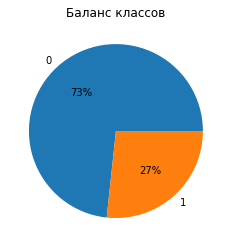

In [38]:
classes = y.value_counts()
plt.title('Баланс классов')
plt.pie(classes, labels=classes.index, autopct='%.0f%%');

Наблюдаем дисбаланс класссов, с которым позже будем бороться

## Обучение модели

### Функции для метрик

In [39]:
def plot_roc_curve(target_test, predictions):
    print('ROC-AUC score', roc_auc_score(target_test, predictions))
    fpr, tpr, thresholds = roc_curve(target_test, predictions)
    plt.figure(figsize=(11, 5))
    plt.plot(fpr, tpr)  
    plt.plot([0, 1], [0, 1], linestyle='--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0]) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')  
    plt.title('ROC-кривая')  
    plt.show()

In [40]:
def scores(model,X,y):
    model_pred = model.predict(X)
    model_pred_prob = model.predict_proba(X)
    auc_roc = roc_auc_score(y, model_pred_prob[:, 1])
    f1_train = 0
    treshold_max = 0
    for threshold in np.arange(0, 0.9, 0.01):
        predicted = model_pred_prob[:, 1] > threshold
        f1 = f1_score(y, predicted)
        if f1_train < f1:
            f1_train = f1
            treshold_max = threshold
    print(f'F1: {f1_train} , порог {treshold_max}')
    plot_roc_curve(y, model_pred_prob[:, 1])
    

### Подготовка данных

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state=290822, shuffle=True, stratify=y)

Проскалируем данные, чтобы не было перевеса каких-то признаков

In [42]:
numeric_columns = ['monthly_charges','duration']
scaler = StandardScaler()

scaler.fit(X_train[numeric_columns])

X_train = X_train.copy()
X_train[numeric_columns] = scaler.transform(X_train[numeric_columns])

X_test = X_test.copy()
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

Так как мы помним, что классы несбалансированы, то дополним их синтетическими данными

In [43]:
smote = SMOTE(random_state=290822)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [44]:
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [3872 3872]
Количество строк в y_test по классам: [1291  470]


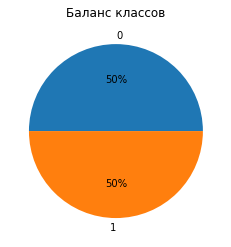

In [45]:
classes = y_train.value_counts()
plt.title('Баланс классов')
plt.pie(classes, labels=classes.index, autopct='%.0f%%');

In [75]:
X_train.columns

Index(['monthly_charges', 'type_month-to-month', 'type_one year',
       'type_two year', 'paperless_billing_1',
       'payment_method_bank transfer (automatic)',
       'payment_method_credit card (automatic)',
       'payment_method_electronic check', 'payment_method_mailed check',
       'internet_service_dsl', 'internet_service_fiber optic',
       'online_security_1', 'online_backup_1', 'device_protection_1',
       'tech_support_1', 'streaming_tv_1', 'streaming_movies_1',
       'senior_citizen_1', 'partner_1', 'dependents_1', 'multiple_lines_1',
       'duration'],
      dtype='object')

Классы сбалансированы

### Dummy

F1: 0.6666666666666666 , порог 0.0
ROC-AUC score 0.5


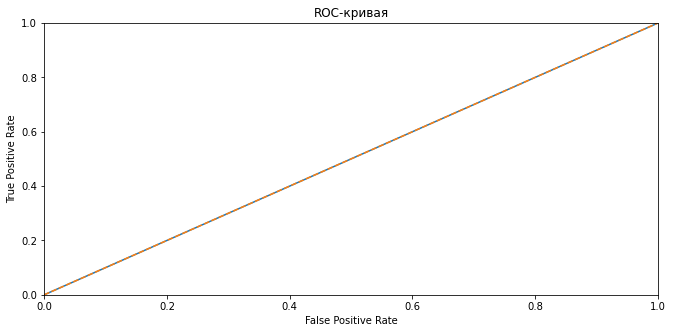

In [47]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
predict_dummy = dummy.predict(X_train)
scores(dummy,X_train,y_train)

### LogisticRegression

In [48]:
lr =  LogisticRegression(random_state=290822)

In [49]:
search_spaces = {'solver': ('lbfgs', 'liblinear')}

In [50]:
opt = BayesSearchCV(lr,
                    search_spaces,
                    scoring="roc_auc",
                    cv=3,
                    n_iter=10,
                    n_jobs=1
                    )

In [51]:
%%time
opt.fit(X_train, y_train)
opt.best_params_

Wall time: 2.18 s


OrderedDict([('solver', 'lbfgs')])

In [52]:
lr = opt.best_estimator_

F1: 0.8042838648934918 , порог 0.4
ROC-AUC score 0.8721644603019773


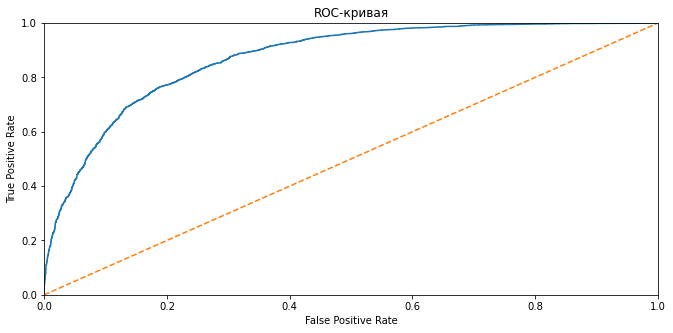

Wall time: 490 ms


In [53]:
%%time
scores(lr, X_train,y_train)

In [54]:
pd.DataFrame(opt.cv_results_)['mean_test_score'].max()

0.8616159976218003

In [55]:
opt.best_score_

0.8616159976218003

### CatBoost

In [113]:
clf = CatBoostClassifier(random_seed=290822, verbose=False)
search_spaces = {'iterations': Integer(100, 1000),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'l2_leaf_reg': Integer(2, 30)}

In [114]:
opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring="roc_auc",
                    cv=3,
                    n_iter=10,
                    n_jobs=1,
                    random_state=290822
                   )

In [ ]:
%%time
opt.fit(X_train, y_train)
opt.best_params_

In [ ]:
cat = opt.best_estimator_

In [ ]:
%%time
scores(cat, X_train, y_train)

Выглядит оч красиво, почаще бы так

In [ ]:
pd.DataFrame(opt.cv_results_)['mean_test_score'].max()

In [112]:
opt.best_score_

0.9550395319313433

### LGBM

In [100]:
lgbm = LGBMClassifier(random_seed=290822)
search_spaces = {'max_depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform')}

In [101]:
opt = BayesSearchCV(lgbm,
                    search_spaces,
                    scoring="roc_auc",
                    cv=3,
                    n_iter=10,
                    n_jobs=1,
                    random_state=290822
                   )

In [102]:
%%time
opt.fit(X_train, y_train)
opt.best_params_

Wall time: 4.56 s


OrderedDict([('learning_rate', 0.25637179355274214), ('max_depth', 5)])

In [103]:
lgbm = opt.best_estimator_

F1: 0.9408299180327869 , порог 0.48
ROC-AUC score 0.9872831098776552


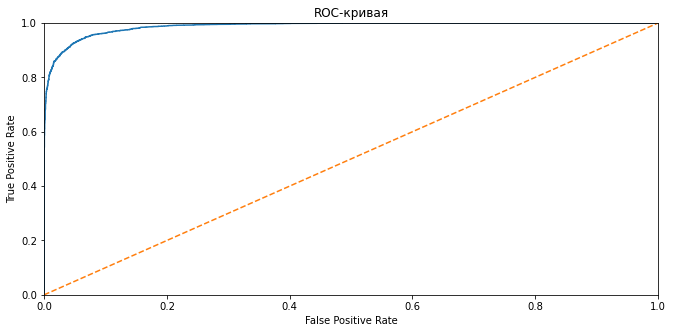

Wall time: 543 ms


In [104]:
%%time
scores(lgbm, X_train,y_train)

In [105]:
pd.DataFrame(opt.cv_results_)['mean_test_score'].max()

0.9408004057056581

In [99]:
opt.best_score_

0.9408004057056581

### Выводы

In [70]:
data = {'Время обучения(сек)':[1.70, 48.9, 2.64], 
        'Время предсказания(мсек)':[432, 401, 463], 
        'ROC-AUC':[0.861, 0.955, 0.941]}
index=['LogisticRegression', 'CatBoost', 'LightGBM']

In [71]:
final = pd.DataFrame(data=data, index=index)
final

,Время обучения(сек),Время предсказания(мсек),ROC-AUC
LogisticRegression,1.70,432,0.861
CatBoost,48.90,401,0.955
LightGBM,2.64,463,0.941


Таким образом лучшая модель на 3х фолдах CV стала CatBoost со значением ROC-AUC: 0.954

## Итоговый тест

F1: 0.7537154989384289 , порог 0.47000000000000003
ROC-AUC score 0.9194521812218797


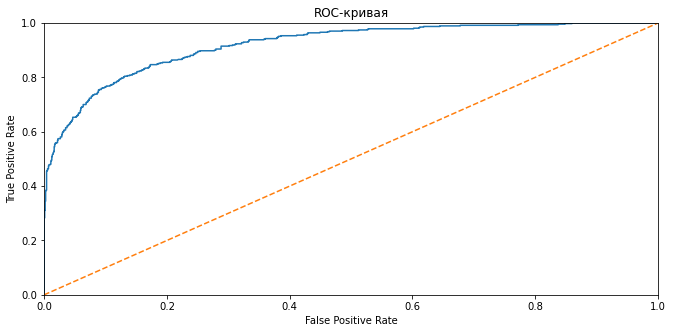

In [72]:
scores(cat, X_test, y_test)

На тестовой выборке модель тоже неплохо себя показала: ROC-AUC = 0.919

In [73]:
print(classification_report(y_test, cat.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1291
           1       0.77      0.74      0.75       470

    accuracy                           0.87      1761
   macro avg       0.84      0.83      0.83      1761
weighted avg       0.87      0.87      0.87      1761



Модель отлично предсказывает тех, кто останется пользоваться услугами компании, и чуть хуже предсказывает тех, кто отвалится

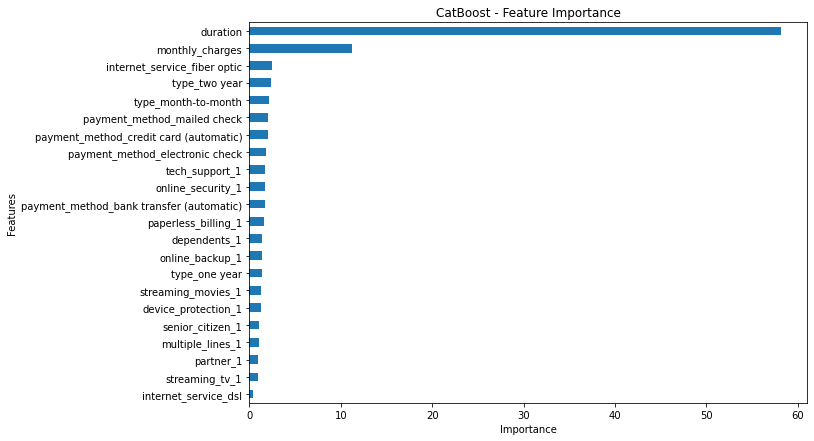

In [74]:
fea_imp = pd.DataFrame({'imp': cat.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

Самым важным признаком для предсказания оказалась: длительность пользования услугами

## Отчет

Мы провели работу, соответственно плану:  
1) **Подготовили данные,**  

Привесли названия столбцов к змеиному регистру;  
Изменили типы данных;  
Добавили столбец с длительностью обслуживания;  
Удалили неинформативные столбцы;  
Составили единую таблицу со всеми данными для модели;  
Провести прямое кодирование признаков.  

2) **Подготовили признаки.**

Выделили целевой признак как факт окончания обслуживания;  
Разбили датасет на выборки;  
Разделили на features и target со смешиванием данных.  

3) **Выбрали модели.**

Использовали и обучение моделей классификации CatBoost, LGBM и LogisticRegression  
Оценили эффективности моделей на кросс-валидации  
Провели финальное тестирование лучшей модели.

Таким образом мы чётко двигались по плану, однаком в ходе работы столкнулись со сложностью в виде дисбаланса классов, который пришлось устранять с помощью SMOTE библитотеки imbalanced-learn.
Лучшей моделью оказался CatBoost с гиперпараметрами:([('depth', 4), ('iterations', 809), ('l2_leaf_reg', 13), ('learning_rate', 0.3317279722609755)], со значением ROC_AUC на тестовой выборке: 0.931. 

В модели мы использовали признаки:
 * ['monthly_charges', 'type_month-to-month', 'type_one year',
 *     'type_two year', 'paperless_billing_1',
 *    'payment_method_bank transfer (automatic)',
 *   'payment_method_credit card (automatic)',
 *  'payment_method_electronic check', 'payment_method_mailed check',
 * 'internet_service_dsl', 'internet_service_fiber optic',
 * 'online_security_1', 'online_backup_1', 'device_protection_1',
 * tech_support_1', 'streaming_tv_1', 'streaming_movies_1',
 * 'senior_citizen_1', 'partner_1', 'dependents_1', 'multiple_lines_1',
 * 'duration'(созданный признак 'длительность пользования услугами']